In [16]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence

from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding,LSTM,Dense,Conv1D,GlobalMaxPooling1D,Input,Lambda,Conv2D
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from keras import backend as K
plt.style.use('ggplot')
%matplotlib inline
import tensorflow_hub as hub


In [17]:
# tf.compat.v1.disable_eager_execution()

### Data Prep

In [18]:
filepath_dict = {'yelp': "datasets/sentiment_labelled_sentences/yelp_labelled.txt",
                 'amazon': "datasets/sentiment_labelled_sentences/amazon_cells_labelled.txt",
                 'imdb': "datasets/sentiment_labelled_sentences/imdb_labelled.txt"
                 }
df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
   # Add another column filled with the source name
    df['source'] = source
    df_list.append(df)  
    df = pd.concat(df_list)

In [19]:
df = df[df['source']== "yelp"]
sentences = df['sentence'].values
y = df['label'].values

sentences_token = [text_to_word_sequence(sentence.strip().lower()) for sentence in sentences]
sentences_len = [len(s) for s in sentences]
maxlen = max(sentences_len)

# tokenizer = Tokenizer(lower=True,num_words=10000)
# tokenizer.fit_on_texts(sentences)
sentences_train,sentences_test,y_train,y_test = train_test_split(
                                                sentences, y,
                                                test_size=0.15,
                                                random_state=1000)

print(Counter(y_train),Counter(y_test))
tokenizer = Tokenizer(lower=True)
#                       ,num_words=10000)
tokenizer.fit_on_texts(sentences_train)

print(tokenizer)
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

# maxlen = 100
vocab_size = len(tokenizer.word_index) + 1

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

# y_train = to_categorical(num_classes=2,y=y_train)
# y_test = to_categorical(num_classes=2,y=y_test)

Counter({1: 428, 0: 422}) Counter({0: 78, 1: 72})


149


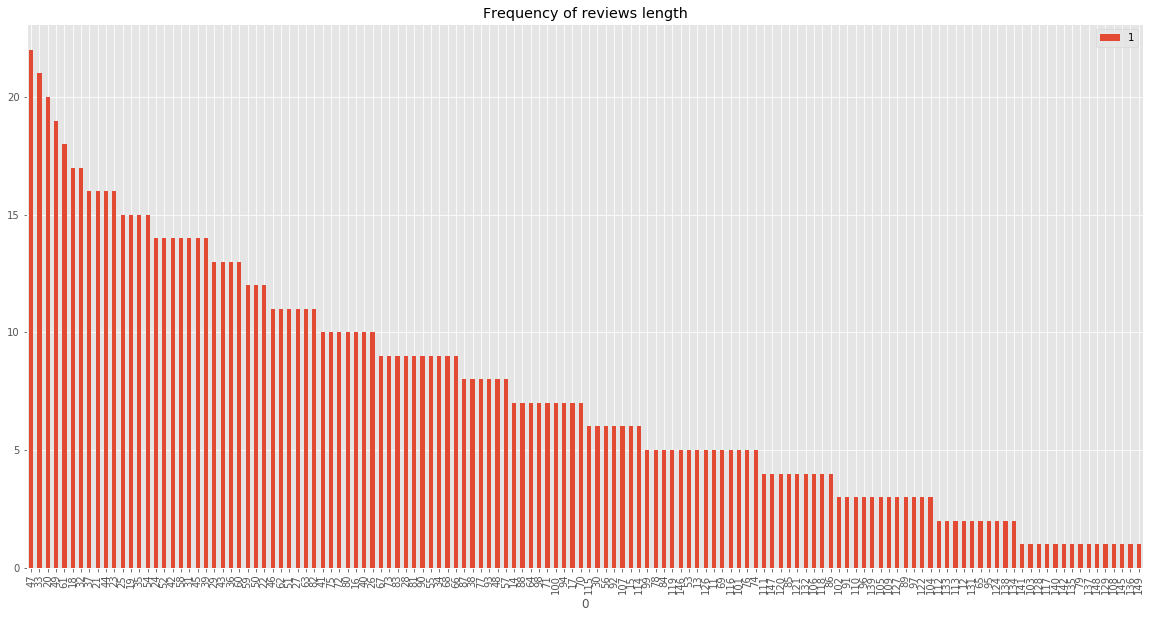

In [59]:
from collections import Counter
import pandas as pd
print(maxlen)
pd.DataFrame(Counter(sentences_len).most_common()).plot(kind="bar",x=0,y=1,figsize=(20,10),
                                                        title="Frequency of reviews length")

In [21]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# module_url = "https://tfhub.dev/google/elmo/3"
module_url = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel("epochs")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel("epochs")
    plt.legend()

### LSTM

In [23]:
import tensorflow_hub as hub


tf.compat.v1.disable_eager_execution()
elmo = hub.Module("https://tfhub.dev/google/elmo/3", trainable=False)
embeddings = elmo(sentences_train,
    signature="default",
    as_dict=True)["elmo"]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [32]:
def ELMoEmbedding(x):
    return elmo(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["elmo"]
def createLSTM():
    hub_layer = hub.KerasLayer("https://tfhub.dev/google/elmo/3", output_shape=[],
                           input_shape=[None,], dtype=tf.string)
    model = tf.keras.Sequential()
    model.add(Input(shape=(1,), dtype="string"))
    model.add(Lambda(ELMoEmbedding, output_shape=(1024, ),name="elmo_embedding_layer"))
#     model.add(hub_layer)
#      embed = hub.KerasLayer(module_url)
#     sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    model.add(LSTM(192,))
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    return model


def createbLSTM():
    model=Sequential()
    model.add(Embedding(input_dim=vocab_size, 
                        output_dim=128, 
                        input_length=maxlen))
    model.add(LSTM(192,))
    model.add(Dense(100,activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
    return model

In [34]:
model= createbLSTM()
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
plot_model(model, to_file='sentiment_basic_embedding_lstm.png',show_shapes=True, show_layer_names=True)
# history = model.fit(sentences_train,y_train,batch_size=16,epochs=3,verbose=1)
# validation_data=(sentences_test, y_test)
history = model.fit(X_train,y_train,batch_size=16,epochs=5,verbose=1,validation_data=(X_test, y_test))
plot_history(history)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 149, 128)          239872    
_________________________________________________________________
lstm_4 (LSTM)                (None, 192)               246528    
_________________________________________________________________
dense_8 (Dense)              (None, 100)               19300     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 101       
Total params: 505,801
Trainable params: 505,801
Non-trainable params: 0
_________________________________________________________________
Train on 850 samples, validate on 150 samples


RuntimeError: Attempted to use a closed Session.

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_120:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_120:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_119:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_119:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_118:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_118:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_117:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_117:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_116:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_116:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_115:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_115:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_114:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_114:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_113:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_113:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_112:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_112:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_111:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_111:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_110:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_110:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_109:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_109:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_108:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_108:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_107:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_107:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_106:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_106:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_105:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_105:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_104:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_104:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_103:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_103:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_102:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_102:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_101:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_101:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_100:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_100:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_99:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_99:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_98:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_98:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_97:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_97:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_96:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_96:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_95:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_95:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_94:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_94:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_93:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_93:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_92:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_92:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_91:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_91:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_90:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_90:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_89:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_89:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_88:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_88:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_87:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_87:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_86:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_86:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_85:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_85:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_84:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_84:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_83:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_83:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_82:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_82:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_81:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_81:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_80:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_80:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_79:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_79:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_78:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_78:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_77:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_77:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_76:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_76:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_75:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_75:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_74:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_74:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_73:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_73:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_72:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_72:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_71:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_71:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_70:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_70:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_69:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_69:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_68:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_68:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_67:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_67:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_66:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_66:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_65:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_65:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_64:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_64:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_63:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_63:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_62:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_62:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_61:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_61:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_60:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_60:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_59:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_59:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_58:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_58:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_57:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_57:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_56:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_56:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_55:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_55:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_54:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_54:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_53:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_53:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_52:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_52:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_51:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_51:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/us

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
elmo_embedding_layer (Lambda (None, None, 1024)        0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 192)               934656    
_________________________________________________________________
dense_10 (Dense)             (None, 16)                3088      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 937,761
Trainable params: 937,761
Non-trainable params: 0
_________________________________________________________________
Train on 850 samples, validate on 150 samples
Epoch 1/5
850/850 [==============================] - 55s 64ms/sample - loss: 0.5934 - accuracy: 0.6941 - val_loss: 0.5771 - val_accuracy: 0.7067
Epoch 2/5
850/850 [==============================] - 58

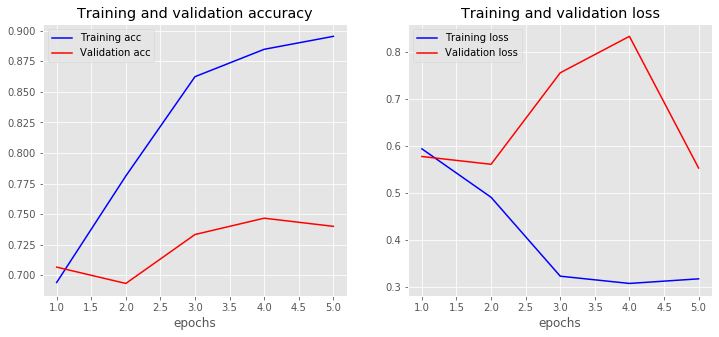

In [35]:
with tf.compat.v1.Session() as session:
    tf.compat.v1.keras.backend.set_session(session)
    session.run(tf.compat.v1.global_variables_initializer())  
    session.run(tf.compat.v1.tables_initializer())
    model= createLSTM()
    model.summary()
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    plot_model(model, to_file='sentiment_elmo_embedding_lstm.png',show_shapes=True, show_layer_names=True)
    history = model.fit(sentences_train,y_train,batch_size=16,epochs=5,verbose=1,validation_data=(sentences_test, y_test))
    # validation_data=(sentences_test, y_test)
    # history = model.fit(embeddings_train,y_train,batch_size=16,epochs=10,verbose=1)
    plot_history(history)
    model.evaluate(sentences_test,y_test)




# CNN

In [44]:



def createCNN(vocab_size,embedding_dim,maxlen):
    model = Sequential()
    model.add(Input(shape=(1,), dtype="string"))
    model.add(Lambda(ELMoEmbedding, output_shape=(1024, ),name="elmo_embedding_layer"))
    
#     model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
#     model.add(Conv1D(64, 5, activation='relu'))
#     model.add(Reshape((3, 4), input_shape=(12,)))
    model.add(Conv1D(32, 3, activation='relu')) #padding= "Same"
#     model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_260:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_260:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_259:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_259:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_258:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_258:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_257:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_257:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_256:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_256:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_255:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_255:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_254:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_254:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_253:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_253:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_252:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_252:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_251:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_251:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_250:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_250:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_249:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_249:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_248:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_248:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_247:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_247:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_246:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_246:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_245:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_245:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_244:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_244:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_243:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_243:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_242:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_242:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_241:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_241:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_240:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_240:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_239:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_239:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_238:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_238:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_237:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_237:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_236:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_236:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_235:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_235:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_234:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_234:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_233:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_233:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_232:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_232:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_231:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_231:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_230:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_230:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_229:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_229:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_228:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_228:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_227:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_227:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_226:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_226:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_225:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_225:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_224:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_224:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_223:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_223:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_222:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_222:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_221:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_221:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_220:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_220:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_219:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_219:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_218:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_218:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_217:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_217:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_216:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_216:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_215:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_215:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_214:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_214:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_213:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_213:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_212:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_212:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_211:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_211:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_210:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_210:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_209:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_209:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_208:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_208:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_207:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_207:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_206:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_206:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_205:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_205:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_204:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_204:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_203:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_203:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_202:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_202:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_201:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_201:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_200:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_200:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_199:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_199:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_198:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_198:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_197:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_197:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_196:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_196:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_195:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_195:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_194:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_194:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_193:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_193:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_192:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_192:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_191:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_191:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_190:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_190:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_189:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_189:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_188:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_188:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_187:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_187:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_186:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_186:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_185:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_185:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_184:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_184:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_183:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_183:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_182:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_182:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_181:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_181:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_180:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_180:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_179:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_179:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_178:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_178:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_177:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_177:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_176:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_176:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_175:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_175:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_174:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_174:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_173:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_173:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_172:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_172:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_171:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_171:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_170:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_170:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_169:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_169:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_168:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_168:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_167:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_167:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_166:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_166:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_165:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_165:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_164:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_164:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_163:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_163:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_162:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_162:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_161:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_161:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_160:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_160:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_159:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_159:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_158:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_158:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_157:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_157:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_156:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_156:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_155:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_155:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_154:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_154:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_153:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_153:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_152:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_152:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_151:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_151:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_150:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_150:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_149:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_149:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_148:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_148:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_147:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_147:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_146:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_146:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_145:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_145:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_144:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_144:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_143:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_143:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_142:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_142:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_141:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_141:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_140:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_140:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_139:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_139:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_138:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_138:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_137:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_137:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_136:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_136:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_135:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_135:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_134:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_134:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_133:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_133:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_132:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_132:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_131:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_131:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_130:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_130:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_129:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_129:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_128:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_128:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_127:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_127:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_126:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_126:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_125:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_125:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_124:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_124:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_123:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_123:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_122:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_122:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_121:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_121:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3363, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 491, in get_session
    _initialize_variables(session)  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in _initialize_variables
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 908, in <listcomp>
    [variables_module.is_variable_initialized(v) for v in candidate_vars])  File "/u

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
elmo_embedding_layer (Lambda (None, None, 1024)        0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          98336     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 32)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 10)                330       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 11        
Total params: 98,677
Trainable params: 98,677
Non-trainable params: 0
_________________________________________________________________
Train on 850 samples, validate on 150 samples
Epoch 1/5
850/850 [==============================] - 50s 59ms/sample 

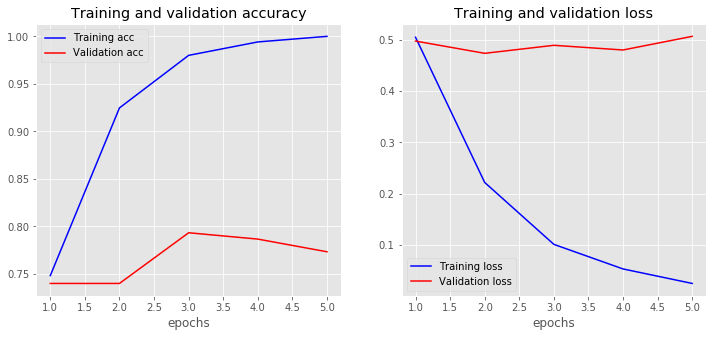

In [45]:

with tf.compat.v1.Session() as session:
    tf.compat.v1.keras.backend.set_session(session)
    session.run(tf.compat.v1.global_variables_initializer())  
    session.run(tf.compat.v1.tables_initializer())
    cnn_model=createCNN(vocab_size,100,maxlen)
    
    cnn_model.summary()
#     plot_model(cnn_model, to_file='sentiment_elmo_embedding_cnn.png',show_shapes=True, show_layer_names=True)
    cnn_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    history = cnn_model.fit(sentences_train,y_train,batch_size=16,epochs=5,validation_data=(sentences_test, y_test),verbose=1)
    plot_history(history)

# cnn_model=createCNN(vocab_size,100,maxlen)
# cnn_model.summary()
# cnn_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc',f1_m,precision_m,recall_m])
